In [63]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
import pickle

##### Read the data

In [2]:
data = pd.read_csv('train.csv')

In [3]:
# User id having corrupt data
data.drop(index=data[data['case_id'] == '0113eba6-6928-461a-b994-35a0b2eb9f4e'].index, inplace=True)

In [4]:
# Huge cardinality in equipment area
data = data.drop(columns=['equipment_area'], axis=1)

In [5]:
data.columns

Index(['case_id', 'equipment_id', 'completion_date',
       'action_recommendation_id', 'action_recommendation_type',
       'action_recommendation_category', 'usage_type', 'speed_category',
       'load_category', 'floors_category', 'equipment_category', 'feedback'],
      dtype='object')

In [7]:
for i in data.columns:
    print(i, ':', len(data[i].unique()))

case_id : 73944
equipment_id : 25599
completion_date : 466
action_recommendation_id : 265
action_recommendation_type : 3
action_recommendation_category : 6
usage_type : 13
speed_category : 8
load_category : 8
floors_category : 8
equipment_category : 20
feedback : 2


In [8]:
merge_columns = ['case_id', 'equipment_id', 'completion_date', 'action_recommendation_id']
data['id'] = data[['case_id', 'equipment_id', 'completion_date', 'action_recommendation_id']].apply(tuple, axis=1)
data_mod = data.drop(['case_id', 'completion_date'], axis=1)
data_mod.head(2)

equipment_id action_recommendation_id action_recommendation_type  \
0   ele0000754               ar00000174                      art01   
1   ele0000789               ar00000248                      art02   

  action_recommendation_category usage_type  speed_category  load_category  \
0                          arc03      ut012               7              6   
1                          arc03      ut005               4              6   

   floors_category equipment_category  feedback  \
0                8              tp006         1   
1                2              tp001         1   

                                                  id  
0  (b7c775ad-4ebe-4848-9c53-37e7c5658e21, ele0000...  
1  (b177eefd-3946-4949-9699-0a91879350f9, ele0000...

In [9]:
len(data_mod['id'].unique())

92298

In [11]:
group = data_mod.groupby('id')

In [13]:
uid = data_mod['id'].unique()
count = 0
idx = []
for i in uid:
    if(len(group.get_group(i)) > 1):
        ind = group.get_group(i).index
        idx.append(ind[0])
        idx.append(ind[1])
        count += 1
print(count)

237


In [14]:
data_mod = data_mod.drop(idx)
len(data_mod['id'].unique())

92077

In [15]:
data_mod.columns

Index(['equipment_id', 'action_recommendation_id',
       'action_recommendation_type', 'action_recommendation_category',
       'usage_type', 'speed_category', 'load_category', 'floors_category',
       'equipment_category', 'feedback', 'id'],
      dtype='object')

##### One Hot encoding of Categorical Variables

In [16]:
data_oh = data_mod.drop(['id', 'equipment_id'], axis=1)
data_onehot = pd.get_dummies(data_oh, prefix=data_oh.columns.difference(['speed_category', 'load_category',
                                                                        'floors_category', 'feedback']))

In [18]:
data_onehot.columns

Index(['speed_category', 'load_category', 'floors_category', 'feedback',
       'action_recommendation_category_ar00000001',
       'action_recommendation_category_ar00000002',
       'action_recommendation_category_ar00000003',
       'action_recommendation_category_ar00000004',
       'action_recommendation_category_ar00000005',
       'action_recommendation_category_ar00000006',
       ...
       'usage_type_tp010', 'usage_type_tp011', 'usage_type_tp012',
       'usage_type_tp013', 'usage_type_tp014', 'usage_type_tp015',
       'usage_type_tp016', 'usage_type_tp017', 'usage_type_tp018',
       'usage_type_tp019'],
      dtype='object', length=311)

##### Feature and Targets

In [19]:
X = data_onehot[data_onehot.columns.difference(['feedback'])]
y = data_onehot['feedback']

##### Clustering the Feature Space

In [21]:
km = KMeans(n_clusters=2, random_state=123)
km.fit(X)

KMeans(n_clusters=2, random_state=123)

In [23]:
X['cluster'] = km.labels_

##### Spliting the data to two groups

In [24]:
# Feature of two different models
X0 = X[X['cluster'] == 0]
X1 = X[X['cluster'] == 1]

In [25]:
X0.shape

(45889, 311)

In [26]:
X1.shape

(46190, 311)

In [30]:
# Target of two different models
y0 = y[X0.index]
y1 = y[X1.index]

##### Train Test Split

In [33]:
X0 = X0.drop(['cluster'], axis=1)
X1 = X1.drop(['cluster'], axis=1)

In [34]:
# Undersampling of the data
rus_0 = RandomUnderSampler(random_state=42, sampling_strategy=0.3)
X_res_0, y_res_0 = rus_0.fit_resample(X0, y0)

rus_1 = RandomUnderSampler(random_state=42, sampling_strategy=0.3)
X_res_1, y_res_1 = rus_0.fit_resample(X1, y1)


In [35]:
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_res_0, y_res_0, test_size=0.3,stratify=y_res_0, random_state=123)

In [36]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_res_1, y_res_1, test_size=0.3,stratify=y_res_1, random_state=123)

In [37]:
X_train_0.shape

(14074, 310)

In [38]:
X_train_1.shape

(23323, 310)

##### Custom f2 score

In [39]:
def f2_score(p, r):
    return (1+4)*((p*r)/(4*p + r))

##### Model for Cluster Zero

In [43]:
rf0 = RandomForestClassifier(class_weight={0:0.8,1:1})
rf0.fit(X_train_0, y_train_0)

RandomForestClassifier(class_weight={0: 0.8, 1: 1})

In [44]:
y_pred_0 = rf0.predict(X_train_0)

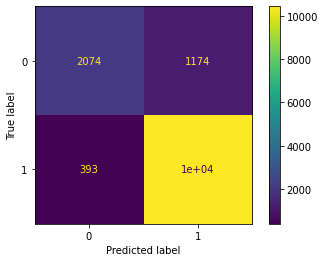

In [45]:
cm = confusion_matrix(y_true=y_train_0,y_pred=y_pred_0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()

In [46]:
print(classification_report(y_true=y_train_0,y_pred=y_pred_0))

              precision    recall  f1-score   support

           0       0.84      0.64      0.73      3248
           1       0.90      0.96      0.93     10826

    accuracy                           0.89     14074
   macro avg       0.87      0.80      0.83     14074
weighted avg       0.89      0.89      0.88     14074



In [50]:
p = precision_score(y_true=y_train_0,y_pred=y_pred_0)
r = recall_score(y_true=y_train_0,y_pred=y_pred_0)

f2 = f2_score(p, r)
print("f2 score for model zero for train data: {}".format(f2))

f2 score for model zero for train data: 0.9499918049206899


#Test predictions

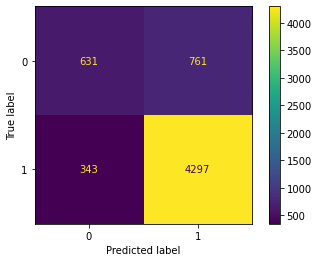

In [51]:
y_pred_0 = rf0.predict(X_test_0)

cm = confusion_matrix(y_true=y_test_0,y_pred=y_pred_0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()

In [52]:
print(classification_report(y_true=y_test_0,y_pred=y_pred_0))

              precision    recall  f1-score   support

           0       0.65      0.45      0.53      1392
           1       0.85      0.93      0.89      4640

    accuracy                           0.82      6032
   macro avg       0.75      0.69      0.71      6032
weighted avg       0.80      0.82      0.80      6032



In [53]:
p = precision_score(y_true=y_test_0,y_pred=y_pred_0)
r = recall_score(y_true=y_test_0,y_pred=y_pred_0)

f2 = f2_score(p, r)
print("f2 score for model zero for train data: {}".format(f2))

f2 score for model zero for train data: 0.9096875264628673


##### Model for Cluster One

In [54]:
rf1 = RandomForestClassifier(class_weight={0:1,1:0.8})
rf1.fit(X_train_1, y_train_1)

RandomForestClassifier(class_weight={0: 1, 1: 0.8})

In [55]:
y_pred_1 = rf1.predict(X_train_1)

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score

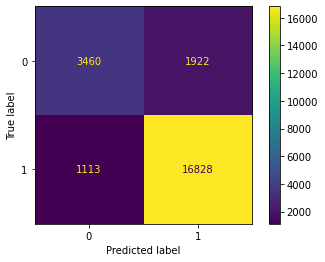

In [57]:
cm = confusion_matrix(y_true=y_train_1,y_pred=y_pred_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()

In [58]:
print(classification_report(y_true=y_train_1,y_pred=y_pred_1))

              precision    recall  f1-score   support

           0       0.76      0.64      0.70      5382
           1       0.90      0.94      0.92     17941

    accuracy                           0.87     23323
   macro avg       0.83      0.79      0.81     23323
weighted avg       0.86      0.87      0.87     23323



In [59]:
p = precision_score(y_true=y_train_1,y_pred=y_pred_1)
r = recall_score(y_true=y_train_1,y_pred=y_pred_1)

f2 = f2_score(p, r)
print("f2 score for model zero for train data: {}".format(f2))

f2 score for model zero for train data: 0.9295799544821794


#Test predictions

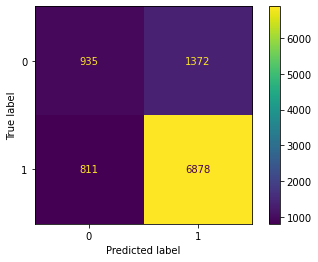

In [60]:
y_pred_1 = rf1.predict(X_test_1)

cm = confusion_matrix(y_true=y_test_1,y_pred=y_pred_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()

In [61]:
print(classification_report(y_true=y_test_1,y_pred=y_pred_1))

              precision    recall  f1-score   support

           0       0.54      0.41      0.46      2307
           1       0.83      0.89      0.86      7689

    accuracy                           0.78      9996
   macro avg       0.68      0.65      0.66      9996
weighted avg       0.76      0.78      0.77      9996



In [62]:
p = precision_score(y_true=y_test_1,y_pred=y_pred_1)
r = recall_score(y_true=y_test_1,y_pred=y_pred_1)

f2 = f2_score(p, r)
print("f2 score for model zero for train data: {}".format(f2))

f2 score for model zero for train data: 0.8816592319130391


##### Saving the models

In [133]:
with open("kmeans.pkl", "wb") as f:
    pickle.dump(km, f)

In [134]:
with open("rf0.pkl", "wb") as f:
    pickle.dump(rf0, f)

In [136]:
with open("rf1.pkl", "wb") as f:
    pickle.dump(rf1, f)

##### Test Data Prediction and Extraction

In [64]:
test_data = pd.read_csv('test.csv')

In [66]:
merge_columns = ['case_id', 'equipment_id', 'completion_date', 'action_recommendation_id']
test_data['id'] = test_data[['case_id', 'equipment_id', 'completion_date', 'action_recommendation_id']].apply(tuple, axis=1)
test_data_mod = test_data.drop(['case_id', 'completion_date'], axis=1)
test_data_mod.shape

(29428, 11)

In [67]:
test_data_oh = test_data_mod.drop(['id', 'equipment_id'], axis=1)
test_data_onehot = pd.get_dummies(test_data_oh, prefix=test_data_oh.columns.difference(['speed_category', 'load_category',
                                                                        'floors_category', 'feedback']))

In [68]:
missing_cols = set( data_onehot.columns ) - set( test_data_onehot.columns ) - set(['feedback'])

In [69]:
for c in missing_cols:
    test_data_onehot[c] = 0

In [71]:
test_data_onehot = test_data_onehot[data_onehot.columns.difference(['feedback'])]

In [75]:
df1 = test_data_onehot[test_data_onehot.columns.difference(['cluster'])]
cluster_arr = km.predict(df1)
test_data_onehot['cluster'] = cluster_arr

##### Classifier Code

In [76]:
def classifier(row):
    if row['cluster'] == 0:
        del row['cluster']
        prediction = rf0.predict([row])
    elif row['cluster'] == 1:
        del row['cluster']
        prediction = rf1.predict([row])
    else:
        print('Warning')
        return 'Warning'
        
    return prediction[0]


In [ ]:
test_data_results = test_data_onehot.copy()
for idx in test_data_onehot.index:
    f = test_data_onehot.iloc[idx]
    a = classifier(f)  
    test_data_results.loc[idx, 'feedback'] = a

C:\Users\Arundev\.conda\envs\hackathon\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Arundev\.conda\envs\hackathon\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Arundev\.conda\envs\hackathon\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Arundev\.conda\envs\hackathon\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Arundev\.conda\envs\hackathon\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warni

In [126]:
test_data_results

action_recommendation_category_ar00000001  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   
...                                          ...   
29423                                          0   
29424                                          0   
29425                                          0   
29426                                          0   
29427                                          0   

       action_recommendation_category_ar00000002  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   
...                                          ...   
29423                                          0   
29424                                          0   
29425                                          0   
29426                                          0   
29427                                          0   

       action_recommendation_category_ar00000003  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   
...                                          ...   
29423                                          0   
29424                                          0   
29425                                          0   
29426                                          0   
29427                                          0   

       action_recommendation_category_ar00000004  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   
...                                          ...   
29423                                          0   
29424                                          0   
29425                                          0   
29426                                          0   
29427                                          0   

       action_recommendation_category_ar00000005  \
0                                              0   
1                                              0   
2                                              1   
3                                              0   
4                                              0   
...                                          ...   
29423                                          0   
29424                                          0   
29425                                          0   
29426                                          0   
29427                                          0   

       action_recommendation_category_ar00000006  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   
...                                          ...   
29423                                          0   
29424                                          0   
29425                                          0   
29426                                          0   
29427                                          0   

       action_recommendation_category_ar00000007  \
0                                              0   
1                                              0   
2                                              0   
3                                              0 

In [129]:
test_data_results['case_id'] = test_data['case_id']
test_data_results['action_recommendation_id'] = test_data['action_recommendation_id']

In [130]:
test_data_results

action_recommendation_category_ar00000001  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   
...                                          ...   
29423                                          0   
29424                                          0   
29425                                          0   
29426                                          0   
29427                                          0   

       action_recommendation_category_ar00000002  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   
...                                          ...   
29423                                          0   
29424                                          0   
29425                                          0   
29426                                          0   
29427                                          0   

       action_recommendation_category_ar00000003  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   
...                                          ...   
29423                                          0   
29424                                          0   
29425                                          0   
29426                                          0   
29427                                          0   

       action_recommendation_category_ar00000004  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   
...                                          ...   
29423                                          0   
29424                                          0   
29425                                          0   
29426                                          0   
29427                                          0   

       action_recommendation_category_ar00000005  \
0                                              0   
1                                              0   
2                                              1   
3                                              0   
4                                              0   
...                                          ...   
29423                                          0   
29424                                          0   
29425                                          0   
29426                                          0   
29427                                          0   

       action_recommendation_category_ar00000006  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   
...                                          ...   
29423                                          0   
29424                                          0   
29425                                          0   
29426                                          0   
29427                                          0   

       action_recommendation_category_ar00000007  \
0                                              0   
1                                              0   
2                                              0   
3                                              0 

In [131]:
test_data_results[['case_id', 'action_recommendation_id', 'feedback']].to_csv('submission.csv', index=False)